<a href="https://colab.research.google.com/github/soumyaa-physics/AI-WINTER-SCHOOL-BROWN-2025/blob/main/Module_2_Model_DCGNN_Particle_Reconstruction_(State).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
pip install awkward dgl -f https://data.pyg.org/whl/torch-2.5.1+cu121.html tqdm performer_pytorch reformer_pytorch torch-geometric torch-cluster -f https://data.pyg.org/whl/torch-2.5.1+cu121.html torch-scatter -f https://data.pyg.org/whl/torch-2.5.1+cu121.html

Looking in links: https://data.pyg.org/whl/torch-2.5.1+cu121.html, https://data.pyg.org/whl/torch-2.5.1+cu121.html, https://data.pyg.org/whl/torch-2.5.1+cu121.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 47.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 105.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 865.1/865.1 kB 50.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 636.7/636.7 kB 42.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.5/8.5 MB 80.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 56.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 5.2 MB/s eta 0:00:00


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### 1. Introduction
(Tempoary head)
Graph Neural Networks have recently emerged as powerful tools in fields such as social network analysis, chemical molecule discovery, and physics applications. In the context of particle physics, GNNs enable us to link scattered detector hits in a natural way, directly modeling how particles deposit energy in detectors. Our goal is to exploit these graph representations to accurately classify different particle showers and ultimately improve event-level inferences, such as distinguishing between signal and background.

Install required libraries

In [4]:
import torch.nn as nn
from mpl_toolkits.mplot3d import Axes3D
from random import randint
from sklearn.cluster import KMeans
from torch_geometric.nn import DynamicEdgeConv
import pandas as pd
from torch.nn import Linear, Sequential, functional as F

###2. Data Preparation
We begin by preparing the dataset. For each event:

Hits are converted into graph nodes, storing 4D spatial coordinates (
𝑥
,
𝑦
,
𝑧,
E), energy, detector layer identifiers, and additional derived features (like radius or layer occupancy).
Edges are built by connecting hits within a predefined layer window or by
 stochastic sampling. The connectivity encourages the GNN to learn which nodes belong to the same particle interaction chain.

This is simply preparing the data.

In [5]:
import glob
import os.path as osp
from random import randint

import numpy as np
import awkward as ak
import torch
from torch_geometric.data import Data, Dataset
import pickle
import tqdm


import matplotlib.pyplot as plt
import seaborn as sns


class DataPrep(Dataset):
    """
    Generate node and edge features based on the layer clusters.
    Loads data from ROOT files via Uproot, filters/clips large events,
    and structures them for PyTorch Geometric.
    """
    url = '/'

    def __init__(self, root, transform=None, max_events=1e8, layer_of_attention=10):
        """
        Args:
            root (str): Directory where the raw data files (.root) are stored.
            transform (callable, optional): Optional transform to be applied on a sample.
            max_events (int, optional): Maximum number of events to process.
            layer_of_attention (int, optional): Maximum allowed difference in layer IDs
                                                for connecteds/nonconnecteds.
        """
        super().__init__(root, transform)
        self.step_size = 500
        self.layer_of_attention = layer_of_attention
        self.masked_array = {}
        self._fill_data(max_events)


    def download(self):
        """
        Mandatory method for 'Dataset' subclasses, but here raises an error
        since we expect the user to handle the raw data manually.
        """
        raise RuntimeError(
            f"Dataset not found. Please download it from {self.url} and move all "
            f"*.root files to {self.raw_dir}."
        )

    def len(self):
        """Returns the total number of events loaded."""
        return len(self.stsCP_vertices_x)

    @property
    def raw_file_names(self):
        """Collects all .root files in the raw directory."""
        return sorted(glob.glob(osp.join(self.raw_dir, '*.root')))

    @property
    def processed_file_names(self):
        """No processed files are generated, so return an empty list."""
        return []

    def get(self, idx):
        """
        Returns a PyTorch Geometric 'Data' object for the event at index 'idx',
        including node features and edges .
        """
        # Flatten coordinates and other features
        lc_x = self.stsCP_vertices_x[idx]
        flat_lc_x = np.expand_dims(np.array(ak.flatten(lc_x)), axis=1)
        lc_y = self.stsCP_vertices_y[idx]
        flat_lc_y = np.expand_dims(np.array(ak.flatten(lc_y)), axis=1)
        lc_z = self.stsCP_vertices_z[idx]
        flat_lc_z = np.expand_dims(np.array(ak.flatten(lc_z)), axis=1)
        lc_e = self.stsCP_vertices_energy[idx]
        flat_lc_e = np.expand_dims(np.array(ak.flatten(lc_e)), axis=1)
        lc_t = self.stsCP_vertices_time[idx]
        flat_lc_t = np.expand_dims(np.array(ak.flatten(lc_t)), axis=1)
        lc_layer_id = self.stsCP_vertices_layer_id[idx]
        flat_lc_layer_id = np.expand_dims(np.array(ak.flatten(lc_layer_id)), axis=1)
        lc_radius = self.stsCP_vertices_radius[idx]
        flat_lc_radius = np.expand_dims(np.array(ak.flatten(lc_radius)), axis=1)
        lc_noh = self.stsCP_vertices_noh[idx]
        flat_lc_noh = np.expand_dims(np.array(ak.flatten(lc_noh)), axis=1)
        lc_eta = self.stsCP_vertices_eta[idx]
        flat_lc_eta = np.expand_dims(np.array(ak.flatten(lc_eta)), axis=1)
        lc_phi = self.stsCP_vertices_phi[idx]
        flat_lc_phi = np.expand_dims(np.array(ak.flatten(lc_phi)), axis=1)

        # Concatenate into node features
        flat_lc_feats = np.concatenate(
            (
                flat_lc_x, flat_lc_y, flat_lc_z,
                flat_lc_e, flat_lc_layer_id, flat_lc_radius,
                flat_lc_noh, flat_lc_eta, flat_lc_phi
            ),
            axis=-1
        )

        # Build edges (pos/neg) and their features
        pos_edges, neg_edges = [], []
        pos_edges_feats, neg_edges_feats = [], []
        offset = 0
        idlc = np.int64(0)

        for cp in range(len(lc_x)):
            n_lc_cp = len(lc_x[cp])
            for _ in range(n_lc_cp):
                random_num_pos = np.int64(randint(offset, offset + n_lc_cp - 1))
                random_num_neg = np.int64(randint(0, flat_lc_x.shape[0] - 1))

                # Ensure the selected pos index is within the layer_of_attention range
                while np.abs(flat_lc_layer_id[random_num_pos] - flat_lc_layer_id[idlc]) > self.layer_of_attention:
                    random_num_pos = np.int64(randint(offset, offset + n_lc_cp - 1))

                # Ensure the selected neg index is within the layer_of_attention range
                while np.abs(flat_lc_layer_id[random_num_neg] - flat_lc_layer_id[idlc]) > self.layer_of_attention:
                    random_num_neg = np.int64(randint(0, flat_lc_x.shape[0] - 1))

                # Avoid picking a negative edge in the same chunk
                while offset <= random_num_neg < offset + n_lc_cp:
                    random_num_neg = np.int64(randint(0, flat_lc_x.shape[0] - 1))

                # Calculate angles and angle differences for edges
                theta1 = np.arctan2(
                    np.sqrt(flat_lc_x[idlc]**2 + flat_lc_y[idlc]**2),
                    flat_lc_z[idlc]
                )
                theta2 = np.arctan2(
                    np.sqrt((flat_lc_x[random_num_pos]-flat_lc_x[idlc])**2 +
                            (flat_lc_y[random_num_pos]-flat_lc_y[idlc])**2),
                    (flat_lc_z[random_num_pos]-flat_lc_z[idlc])
                )
                theta3 = np.arctan2(
                    np.sqrt((flat_lc_x[random_num_neg]-flat_lc_x[idlc])**2 +
                            (flat_lc_y[random_num_neg]-flat_lc_y[idlc])**2),
                    (flat_lc_z[random_num_neg]-flat_lc_z[idlc])
                )
                theta_diff_pos = theta1 - theta2
                theta_diff_neg = theta1 - theta3

                # Build edges
                pos_edges.append([idlc, random_num_pos])
                neg_edges.append([idlc, random_num_neg])

                pos_edges_feats.append([
                    np.abs(flat_lc_e[idlc] - flat_lc_e[random_num_pos]),
                    theta_diff_pos,
                    theta1
                ])
                neg_edges_feats.append([
                    np.abs(flat_lc_e[idlc] - flat_lc_e[random_num_neg]),
                    theta_diff_neg,
                    theta1
                ])

                idlc += 1
            offset += n_lc_cp

        # Convert to PyTorch Tensors
        x = torch.from_numpy(flat_lc_feats).float()

        x_pos_edge = torch.from_numpy(np.array(pos_edges))
        x_neg_edge = torch.from_numpy(np.array(neg_edges))
        edge_index = torch.cat([x_pos_edge, x_neg_edge], dim=0).t().contiguous()

        x_pos_edge_feats = torch.from_numpy(np.array(pos_edges_feats)).float()
        x_neg_edge_feats = torch.from_numpy(np.array(neg_edges_feats)).float()
        edge_attr = torch.cat([x_pos_edge_feats, x_neg_edge_feats], dim=0).squeeze(dim=2)

        return Data(x=x, edge_index=edge_index, edge_attr=edge_attr)




### 3. Load and Visalize

In [6]:
#Data Loading, batch size and shuffle parameters
import os
from torch_geometric.loader import DataLoader
current_path = os.getcwd()
#ipath = current_path +  '/drive/MyDrive/GNN Particle Reconstruction/Multiphoton/train_a'
#vpath = current_path +  '/drive/MyDrive/GNN Particle Reconstruction/Multiphoton/test_a'
def load_object(filename):
    with open(filename, 'rb') as f:
        return pickle.load(f)

print("Current Path:", current_path)

# Personal folder location
winter_school_drive = "AI WINTER SCHOOL-SOUMYAA/"
local_path = '/content/drive/My Drive/AI WINTER SCHOOL-SOUMYAA/Module 2/'
module_path = 'Module 2/'
data_train = load_object(local_path +"datatrain.pkl")# "/drive/MyDrive/GNN Particle Reconstruction/datatrain.pkl")
data_test = load_object(local_path + "datatest.pkl") #"/drive/MyDrive/GNN Particle Reconstruction/datatest.pkl")
print('trainig data loaded', local_path +"datatrain.pkl")
print('testing data loaded', local_path + "datatest.pkl")

BATCHSIZE = 10
ATTENTION_LAYER = 5 # How many of the layers to look at with each particle (i.e. last 5)


#data_train = DataPrep(ipath,max_events=24000,layer_of_attention = ATTENTION_LAYER)

#data_test = DataPrep(vpath,max_events=9000,layer_of_attention = ATTENTION_LAYER)

train_loader = DataLoader(data_train, batch_size=BATCHSIZE,shuffle=True, follow_batch=['x'])
#print('loading test data at:',vpath)
test_loader = DataLoader(data_test, batch_size=BATCHSIZE,shuffle=False, follow_batch=['x'])



Current Path: /content
trainig data loaded /content/drive/My Drive/AI WINTER SCHOOL-SOUMYAA/Module 2/datatrain.pkl
testing data loaded /content/drive/My Drive/AI WINTER SCHOOL-SOUMYAA/Module 2/datatest.pkl


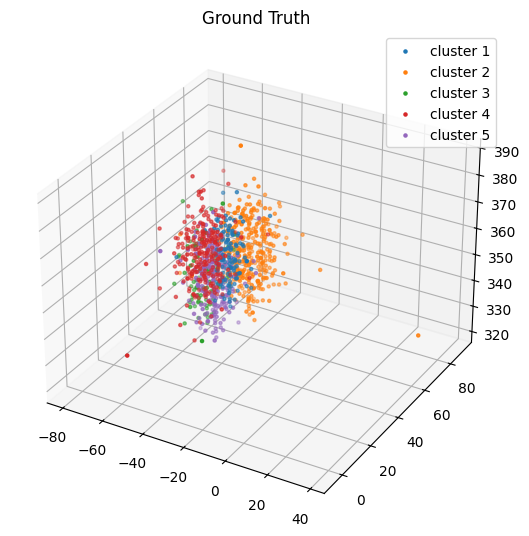

In [7]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
event_index = 1  # Example: plot event at index 0

def _plot_data(data, idx, plot_type='both', model_name=None, device='cpu', net=None, data_title=None):

    data_to_plot = data[idx].to(device)
    x = data_to_plot.x[:, 0].cpu().detach().numpy() #convert a tensor from GPU memory into a NumPy array
    y = data_to_plot.x[:, 1].cpu().detach().numpy() #detach the tensor from the computational graph, no gradients are tracked
    z = data_to_plot.x[:, 2].cpu().detach().numpy()

    fig_size = (14, 7) if plot_type == 'both' else (7, 7)
    fig = plt.figure(figsize=fig_size)


    #num_labels = clustering.number_of_clusters
    num_particles = len(data.stsCP_vertices_x[idx])

    # Use a color palette with up to 10 distinct colors
    #color_palette = sns.color_palette("husl", max(min(num_labels, 10), num_particles))

    x_range = max(x) - min(x)
    y_range = max(y) - min(y)
    z_range = max(z) - min(z)

    # Ground Truth Plot
    if plot_type in ['ground_truth', 'both']:
      ax1 = fig.add_subplot(121 if plot_type == 'both' else 111, projection='3d')
      ax1.set_title('Ground Truth')
      for i in range(num_particles):
          x1 = data.stsCP_vertices_x[idx][i]
          y1 = data.stsCP_vertices_y[idx][i]
          z1 = data.stsCP_vertices_z[idx][i]
          ax1.scatter(x1, y1, z1, label=f'cluster {i+1}', s=5)
      ax1.set_xlim(min(x) - 0.1 * x_range, max(x) + 0.1 * x_range)
      ax1.set_ylim(min(y) - 0.1 * y_range, max(y) + 0.1 * y_range)
      ax1.set_zlim(min(z) - 0.1 * z_range, max(z) + 0.1 * z_range)
      ax1.axison = False
      ax1.legend()


    plt.show()
_plot_data(data_train, event_index, data_title='Train Data Example')

### 4. GNN Architecture
We define a Net class that comprises several message-passing layers, specifically DynamicEdgeConv from the Torch Geometric library. This layer type dynamically computes k-nearest neighbors in the latent space, allowing the model to reshape the graph structure at every layer. Key steps in the model include:

Feature Encoding: An initial MLP transforms raw node features into a latent representation.

Message Passing: Multiple DynamicEdgeConv layers iteratively update these node embeddings based on neighbor information.

Output Projection: A final linear block condenses the node embeddings into a lower-dimensional latent space, facilitating clustering or downstream classification.

Edge Convolution Overview
Input Data:

    Set of Points: X={x1,…,xn}⊂RFX={x1​,…,xn​}⊂RF
        n: Number of points
        FF: Dimensionality of each point (e.g., xi=(xi,yi,zi)xi​=(xi​,yi​,zi​) for 3D coordinates).
    Features can include:
        Color
        Surface normals
        Other descriptors.

Graph Representation:

    Graph G=(V,E):
        V={1,…,n}: Vertices (nodes).
        E⊆V×V: Edges.
        k-nearest neighbors (k-NN): Graph is built using k-NN in RF, including self-loops.
    Edge Feature eij​:
        eij=hθ(xi,xj)eij​=hθ​(xi​,xj​) (learned relationship between xixi​ and xjxj​).

Standard convolution for the mm-th filter:

    xim′​=j:(i,j)∈E∑​θm​⋅xj​

PointNET, PointCNN:

    PointNet:
    hθ(xi,xj)=hθ(xi)  h is a function of initial point

    PointCNN:
    hθ(xi,xj)=hθ(xj) h is a function of neighboring points



Pairwise Distance:
\( x'_{im} = \sum_{j \in V} h_\theta(x_i, x_j) \)


Gaussian Kernel:

    hθ(xi,xj)hθ​(xi​,xj​) represents a Gaussian kernel in Euclidean space.

Encoding Local Information or Global & Local Information:

    hθ(xi,xj)=hθ(xj−xi)
    hθ(xi,xj)=hθ(xj−xi,xi)


For Graph CNN, the edge convolution contains both glabal and local information. The edge features are then aggregated using max pooling where j is the set of all neighbors of i (i.e. connected via a edge). Max pooling ensures that only the strongest signal for each node is propagated to the next layer, highlighting the most relevant interactions.

    eijm′=ReLU(θm⋅(xj−xi)+ϕm⋅xi)
    xim′=max⁡j:(i,j)∈Eeijm′

Key Concepts:

    Choice of kk:
        Determines the number of neighbors for each point.
    Aggregation Operators:
        Sum (∑): Accumulates features from all neighbors.
        Max (max): Selects the most prominent feature.
        Dynamically updates the edge features for the next layer by recomputing kk-nearest neighbors.


In [ ]:
import torch
import torch.nn as nn
from torch_geometric.nn import DynamicEdgeConv
import torch_cluster

class Net(nn.Module):
    """
    A neural network that processes input features with multiple DynamicEdgeConv layers
    and outputs a feature vector (e.g., for classification or regression).

    Args:
        input_dim (int): Number of input features per node.
        hidden_dim (int): Number of hidden units in the linear and edge-conv layers.
        output_dim (int): Number of output features (e.g., classes or regression targets).
        k (int): Number of neighbors to consider in the DynamicEdgeConv layers.

    Forward Args:
        x_lc (torch.Tensor): Node feature matrix [num_nodes, input_dim].
        batch_lc (torch.Tensor): Batch index vector [num_nodes].

    Returns:
        torch.Tensor: Output feature matrix [num_nodes, output_dim].
    """
    def __init__(self, input_dim, hidden_dim, output_dim, k):
        super().__init__()

        # Initial encoding of the node features
        self.lc_encode = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ELU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ELU(),
        )

        # Helper to create multiple DynamicEdgeConv layers
        def create_conv_layer(dim, neighbors):
            return DynamicEdgeConv(
                nn=nn.Sequential(
                    nn.Linear(2 * dim, dim),
                    nn.ELU(),
                    nn.BatchNorm1d(dim)
                ),
                k=neighbors
            )

        # Stacked DynamicEdgeConv layers
        self.conv1 = create_conv_layer(hidden_dim, k)
        self.conv2 = create_conv_layer(hidden_dim, k)
        self.conv3 = create_conv_layer(hidden_dim, k)
        self.conv4 = create_conv_layer(hidden_dim, k)  # Optional or unused

        # Final output projection
        self.output = nn.Sequential(
            nn.Linear(32, 32),
            nn.ELU(),
            nn.Linear(32, 16),
            nn.ELU(),
            nn.Linear(16, output_dim),
        )

    def forward(self, x_lc, batch_lc):
        # Encode input node features
        x_encoded = self.lc_encode(x_lc)

        # Pass through successive DynamicEdgeConv layers
        feats1 = self.conv1((x_encoded, x_encoded), (batch_lc, batch_lc))
        feats2 = self.conv2((feats1, feats1), (batch_lc, batch_lc))
        #feats3 = self.conv3((feats2, feats2), (batch_lc, batch_lc))
        # feats4 = self.conv4((feats3, feats3), (batch_lc, batch_lc))  # Uncomment if needed

        # Apply the output projection
        out = self.output(feats2)
        return out


### 5. Loss Function: Alignment-Diffusion
We use a custom alignment-diffusion loss that:

Aligns embeddings of hits belonging to the same particle (minimizing their distance).
Disperses embeddings for hits belonging to different particles (maximizing separation).
This approach helps the network learn an interpretable latent space where hits from the same shower form distinct clusters.This loss function will separate the particles in the detector into their own sections of the latent space which we will then use to cluster the data better subsequently.

In [ ]:
#Loss Function

def alignment_diffusion_loss(start_all, end_all, temperature=0.1):
    # Normalize embeddings
    z_start = F.normalize(start_all, dim=-1)
    z_end = F.normalize(end_all, dim=-1)

    # Split into same particles and separate
    half_size = len(z_start) // 2
    z_start_same = z_start[:half_size]
    z_end_same = z_end[:half_size]  # Same particles
    z_start_sep = z_start[half_size:]
    z_end_sep = z_end[half_size:]  # Separate particles

    # Alignment term: minimize cosine distance between connected inputs
    alignment_loss = 1 - torch.mean(F.cosine_similarity(z_start_same, z_end_same, dim=-1))


    dispersion_loss = torch.mean(F.cosine_similarity(z_start_sep,z_end_sep))  # Encourage larger distances

    # Total loss: balance alignment and dispersion
    loss = alignment_loss + temperature * dispersion_loss

    return loss



### 5.Training Procedure
Our training loop:

Batches the data with a PyTorch Geometric DataLoader.
For each batch:
Performs a forward pass through the GNN.
Computes the alignment-diffusion loss using node embeddings and edge indices.
Updates the model parameters through backpropagation.
We monitor both training and validation loss across epochs to guard against overfitting. The best model checkpoint is saved whenever validation loss reaches a new minimum.We build our training loop

In [ ]:
#Training, Testing and Plotting Functions

def train(cc, optimizer, train_loader, model, device,len_of):
    cc.train()
    counter = 0
    total_loss = 0
    np.random.shuffle(train_loader)
    for data in tqdm.tqdm(train_loader):


        counter += 1
        data = data.to(device)
        optimizer.zero_grad()


        out = cc(data.x, data.x_batch)

        values,counts = np.unique(data.batch.detach().cpu().numpy(), return_counts=True)
        losses = []

        for e in range(len(counts)):
            lower_edge = 0 if e == 0 else np.sum(counts[:e])
            upper_edge = lower_edge + counts[e]
            start_all = out[data.edge_index[0][2*lower_edge:2*upper_edge]]
            end_all = out[data.edge_index[1][2*lower_edge:2*upper_edge]]
            if len(losses) == 0:
                losses.append(alignment_diffusion_loss(start_all,end_all,1))
            else:
                losses.append(losses[-1]+alignment_diffusion_loss(start_all,end_all,1))

        loss = losses[-1]

        loss.backward()
        total_loss += loss.item()

        optimizer.step()
    return total_loss / len_of

@torch.no_grad()
def test(cc, test_loader, model, device,len_of):
    cc.eval()
    total_loss = 0
    counter = 0
    for data in tqdm.tqdm(test_loader):
        counter += 1
        data = data.to(device)
        with torch.no_grad():

            if model == 'DGCNN':
                out = cc(data.x, data.x_batch)
            values,counts = np.unique(data.x_batch.detach().cpu().numpy(), return_counts=True)

            losses = []
            for e in range(len(counts)):
                lower_edge = 0 if e == 0 else np.sum(counts[:e])
                upper_edge = lower_edge + counts[e]
                start_all = out[data.edge_index[0][2*lower_edge:2*upper_edge]]
                end_all = out[data.edge_index[1][2*lower_edge:2*upper_edge]]

                if len(losses) == 0:
                    losses.append(alignment_diffusion_loss(start_all,end_all,1))
                else:
                    losses.append(losses[-1]+alignment_diffusion_loss(start_all,end_all,1))

            loss = losses[-1]
            total_loss += loss.item()
    return total_loss / len_of

Here we use a graph neural network

In [ ]:
Latent_vec = 8#Model Initialization, Training and Saving

def initialize_model(model_name, device, input_dim, edge_feature_dim):

    if model_name == 'DGCNN':
        #input_dim, hidden_dim, output_dim, k
        return Net(input_dim, 32, Latent_vec, 30).to(device)

def load_previous_state(opath, model, optimizer, scheduler):
    pt_files = [int(f.split('-')[-1].replace('.pt', '')) for f in glob.glob(os.path.join(opath, "epoch-*.pt"))]
    if pt_files:
        latest_epoch = max(pt_files)
        checkpoint_path = os.path.join(opath, f"epoch-{latest_epoch}.pt")
        print(f"Loading model from {checkpoint_path}")
        checkpoint = torch.load(checkpoint_path, map_location=torch.device('cpu'))
        #checkpoint = torch.load(checkpoint_path)
        model.load_state_dict(checkpoint['model'])
        #optimizer.load_state_dict(checkpoint['optimizer'])
        #scheduler.load_state_dict(checkpoint['scheduler'])
        loss_df = pd.read_csv(os.path.join(opath, 'loss.csv'))
        return latest_epoch, loss_df['train_loss'].tolist(), loss_df['test_loss'].tolist()
    else:
        print(f"No model found in {opath}")
        return 0, [], []

def save_training_state(epoch, opath, model, optimizer, scheduler, loss_dict):
    state_dict = {'model': model.state_dict(), 'optimizer': optimizer.state_dict(), 'scheduler': scheduler.state_dict(), 'lr': scheduler.get_last_lr()}
    if epoch % 5 == 0:
        torch.save(state_dict, os.path.join(opath, f"epoch-{epoch}.pt"))
        pd.DataFrame(loss_dict).to_csv(os.path.join(opath, 'loss.csv'), index=False)

def train_model(data_training, data_testing, training_epochs, model_name, BATCHSIZE, optimizer_lr, scheduler_step_size, scheduler_gamma, train_loader, test_loader, opath, device, input_dim, edge_feature_dim, layer_of_attention):
    if not os.path.exists(opath):
        os.makedirs(opath, exist_ok=True)

    params_path = os.path.join(opath, 'training_parameters.txt')
    with open(params_path, 'w') as file:
        parameters = [
            'data processing parameters:\n',
            f'Batch Size: {BATCHSIZE}\n',
            f'Number of layer window: {layer_of_attention}\n',
            '=' * 50 + '\n',
            'model parameters: \n',
            f'model: {model_name}\n',
            f'optimizer_lr: {optimizer_lr}\n',
            f'scheduler_step_size: {scheduler_step_size}\n',
            f'scheduler_gamma: {scheduler_gamma}\n',
            f'training_epochs: {training_epochs}\n'
        ]
        file.writelines(parameters)

    model = initialize_model(model_name, device, input_dim, edge_feature_dim)
    optimizer = torch.optim.AdamW(model.parameters(), lr=optimizer_lr)
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=scheduler_gamma)

    starting_epoch, all_train_loss, all_test_loss = load_previous_state(opath, model, optimizer, scheduler)
    best_loss = min(all_test_loss, default=1e9)
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=scheduler_gamma)

    loss_dict = {'train_loss': all_train_loss, 'test_loss': all_test_loss}

    for epoch in range(starting_epoch + 1, training_epochs + 1):
        if epoch % 1001 == 0:
          data_training = [data for data in train_loader]

        train_loss = train(model, optimizer, data_training, model_name, device,len(train_loader.dataset))
        test_loss = test(model, data_testing, model_name, device,len(test_loader.dataset))
        # comparisons = run_evaluation(data_test, model, device, model, 'Test', threshold = 0.8, temperature = 1, ATTENTION_NUMBER = 4, ATTENTION_LAYER = ATTENTION_LAYER, SPARSE = False, save = False, clustering_method = 'Variable', opath = opath)
        print(f"Epoch {epoch}/{training_epochs}: Train loss: {train_loss}, Val loss: {test_loss}, LR: {scheduler.get_last_lr()}")

        all_train_loss.append(train_loss)
        all_test_loss.append(test_loss)

        if test_loss < best_loss:
            best_loss = test_loss
            torch.save({'model': model.state_dict(), 'optimizer': optimizer.state_dict(), 'scheduler': scheduler.state_dict()}, os.path.join(opath, "best_model.pt"))

        save_training_state(epoch, opath, model, optimizer, scheduler, loss_dict)
        scheduler.step()

    return all_train_loss, all_test_loss


In [ ]:
import time
start_time_data = time.time()
#Caching data to save time on training
#data_training =[data for data in train_loader]#

print('Total time caching: ', time.time()-start_time_data, 'Average time: ', (time.time()-start_time_data)/len(data_training))

#data_testing = [data for data in test_loader]# Model parameters

model = 'DGCNN'


#Node and Edge feature dimensions
node_feature_dim = 9
edge_feature_dim = 1

#Output directory
current_time = time.strftime("%H-%M-%S")
current_date = time.strftime("%Y%m%d")
directory = os.path.join(current_path, 'experiments', current_date)


opath = local_path +"M3"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')




In [ ]:
#Training parameters

optimizer_lr = 0.00026
scheduler_step_size = 25
scheduler_gamma = 0.95

data_s_t = data_training
training_epochs = 25
out = train_model(data_training, data_testing, training_epochs, model, BATCHSIZE, optimizer_lr, scheduler_step_size, scheduler_gamma, train_loader, test_loader, opath, device, node_feature_dim, edge_feature_dim, layer_of_attention = ATTENTION_LAYER)

Loading model from /content/drive/MyDrive/GNN Particle Reconstruction/M3/epoch-70.pt


<ipython-input-44-006f60620313>:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=torch.device('cpu'))


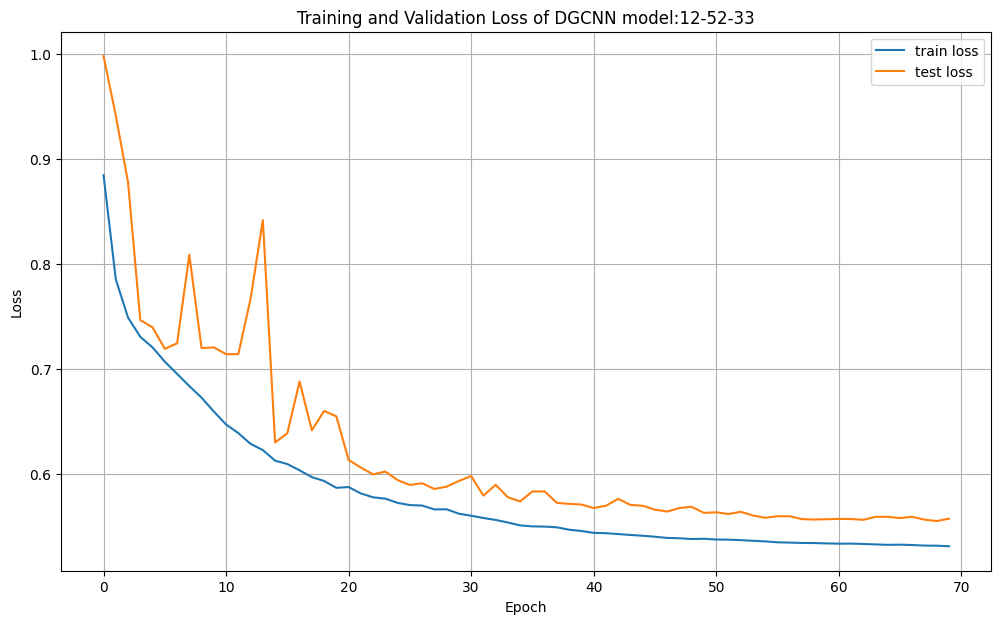

In [ ]:
#Plot Loss
fig,ax = plt.subplots(figsize = (12,7))
all_train_loss = out[0]
all_test_loss = out[1]
ax.plot(all_train_loss, label='train loss')
ax.plot(all_test_loss, label='test loss')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.set_title(f'Training and Validation Loss of {model} model:' + current_time)

ax.legend()#ax.set_xticks(np.arange(0,training_epochs + 1, 1))
ax.grid()
plt.show()

In [ ]:

from sklearn.cluster import MeanShift, OPTICS#Result Visualization

best_model = torch.load(f"{opath}/best_model.pt", map_location=torch.device('cpu'))


cc = None
model == 'DGCNN'

cc = Net(9, 32, Latent_vec, 30).to(device)

cc.load_state_dict(best_model['model'])
cc.eval()
cc.to(device)


for data in data_s_t:
    data = data.to(device)
    if model == 'DGCNN':
        out = cc(data.x, data.batch)

    with torch.no_grad():
        value, counts = np.unique(data.x_batch.detach().cpu().numpy(), return_counts=True)
        #print(value, counts)


<ipython-input-75-e9ac44b338c4>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model = torch.load(f"{opath}/best_model.pt", map_location=torch.device('cpu'))


### 6. Clustering and Evaluation
After training, we extract node embeddings from the final GNN layer to:

Cluster them (e.g., using K-Means) into distinct groups, each expected to correspond to one underlying particle.
Evaluate the quality of reconstruction by measuring purity and energy-weighted purity: these metrics gauge how accurately each cluster corresponds to a single true particle.


Clustering: We are going to use K-Means, we specify the number of clusters to the right number of clusters and to observe if the model is learning we will look at the real space K-Means clustering vs. the latent space clustering.



Metrics: We will define 2 metrics to evaluate the quality of the clusters

Purity: How much of the cluster is made of the same particle

Energy Weighted Purity: How much of the energy in the cluster is the same particle

In [ ]:

from sklearn.cluster import KMeans

class Layer_wise_Cluster:
    """
    Layer-wise clustering class.
    Performs clustering on model outputs and raw inputs using specified methods.
    """

    def __init__(
        self,
        out,
        raw_input,
        threshold,
        temperature,
        number_of_attention,
        layer_of_attention,
        similarity_matrix=None,
        sparse=False,
        save=False,
        index=None,
        clustering_method='iterative_clustering',
        opath=None,
        pre_cluster=None,
        number_of_clusters=None
    ):
        """
        Initializes clustering settings and performs clustering if no pre-cluster is provided.

        Args:
            out (torch.Tensor): Model output (will be detached to NumPy).
            raw_input (np.ndarray): Original input features (x, y, z, E, layer_id, etc.).
            threshold (float): Clustering threshold.
            temperature (float): A parameter that may be used for softmax or other heuristics.
            number_of_attention (int): Number of attention heads used (if relevant).
            layer_of_attention (int): Layer index used for attention (if relevant).
            similarity_matrix (np.ndarray, optional): Precomputed similarity matrix.
            sparse (bool, optional): Whether to use sparse representation (not used here directly).
            save (bool, optional): Whether to save clustering results.
            index (int, optional): Event index in the dataset.
            clustering_method (str, optional): Clustering method (e.g. 'A KMeans raw', 'KMeans').
            opath (str, optional): Output path for saving results.
            pre_cluster (list, optional): Predefined clusters if available.
            number_of_clusters (int, optional): Number of clusters to use (e.g. for KMeans).
        """
        # Basic properties
        self.out = out.detach().cpu().numpy()  # Convert model output to NumPy
        self.raw_input = raw_input
        self.rawxyzE = raw_input[:, 0:3]
        self.energy = raw_input[:, 3]
        self.layer_id = raw_input[:, 4].astype(int)

        self.threshold = threshold
        self.temperature = temperature
        self.number_of_attention = number_of_attention
        self.layer_of_attention = layer_of_attention
        self.output_path = opath
        self.save = save
        self.event_index = index
        self.clustering_method = clustering_method
        self.num_of_clusters = number_of_clusters
        self.max_layer = np.max(self.layer_id)
        self.clustered_particle_mask = np.zeros(len(self.layer_id), dtype=bool)

        # Either load pre_cluster or perform a new clustering
        if pre_cluster is not None:
            self.cluster = {}
            for cluster_list in pre_cluster:
                seed = cluster_list[0]
                self.cluster[seed] = cluster_list
        else:
            self.cluster = self._clustering()

        # Post-processing and cluster metadata
        self.sorted_cluster = self._get_sorted()
        self.labels_ = self._get_labels_()
        self.number_of_clusters = self._get_number_of_clusters()
        self.n_features_in = self._get_features_in()
        self.cluster_energy = self._get_sorted_cluster_energy()
        self.sorted_by_energy = self._get_sorted_by_energy()

    def _clustering(self):
        """
        Clusters data according to self.clustering_method and returns a dictionary
        { cluster_label: [list of indices in that cluster] }.
        """
        if self.clustering_method == 'A KMeans raw':
            model = KMeans(n_clusters=self.num_of_clusters, n_init=25)
            clustering = model.fit(self.rawxyzE)
            labels = clustering.labels_

        elif self.clustering_method == 'KMeans':
            model = KMeans(n_clusters=self.num_of_clusters, max_iter=1000)
            clustering = model.fit(self.out)
            labels = clustering.labels_

        else:
            raise ValueError(f"Unknown clustering method: {self.clustering_method}")

        cluster_dict = {}
        for i, label in enumerate(labels):
            cluster_dict.setdefault(label, []).append(i)
        return cluster_dict

    def _get_sorted(self):
        """
        Sorts clusters by their number of particles (descending).
        Returns a list of lists (each list is cluster members).
        """
        sorted_cluster_items = sorted(
            self.cluster.items(),
            key=lambda x: len(x[1]),
            reverse=True
        )
        return [members for _, members in sorted_cluster_items]

    def _get_labels_(self):
        """
        Assigns a cluster label to each particle.
        Returns a 1D array of labels in the same order as original data.
        """
        labels_ = np.zeros(len(self.layer_id), dtype=int)
        sorted_clusters = self._get_sorted()
        for cluster_index, members in enumerate(sorted_clusters):
            labels_[members] = cluster_index
        return labels_

    def _get_number_of_clusters(self):
        """
        Returns the number of unique clusters.
        """
        return len(self.cluster.keys())

    def _get_features_in(self):
        """
        Returns the number of features in the raw input data.
        """
        return self.raw_input.shape[1]

    def _get_sorted_cluster_energy(self):
        """
        Returns a list of (seed_particle, total_energy_of_cluster),
        sorted by descending cluster energy.
        """
        cluster_energy = []
        for seed, members in self.cluster.items():
            total_energy = np.sum(self.energy[members])
            cluster_energy.append((seed, total_energy))
        cluster_energy.sort(key=lambda x: x[1], reverse=True)
        return cluster_energy

    def _get_sorted_by_energy(self):
        """
        Returns a list of clusters (each cluster is a list of particle indices),
        sorted by descending cluster energy.
        """
        cluster_energy = self._get_sorted_cluster_energy()
        return [self.cluster[seed] for seed, _ in cluster_energy]


In [ ]:
class Comparison:
    """
    Class for comparing predicted vs. ground truth clusters, and visualizing results.
    """
    def __init__(self, clustering, data, idx, model_name=None, device='cpu', net=None,
                 data_title=None, make_graph=True):
        self.clustering = clustering
        self.data = data
        self.idx = idx
        self.purity = self._metrics(self.clustering, self.data.stsCP_vertices_energy, self.idx)

        # Optional visualization
        if make_graph:
            self.draw = self._plot_data(
                self.data, self.idx,
                plot_type='both',
                model_name=model_name,
                device=device,
                net=net,
                data_title=data_title,
                clustering=clustering
            )

    def _purity(self):
        """
        Returns the arithmetic mean of ratio and weighted energy purity.
        """
        ratio, weighted_energy = self._metrics(self.clustering, self.data.stsCP_vertices_energy, self.idx)[:2]
        return np.mean(ratio), np.mean(weighted_energy)

    def _plot_data(self, data, idx, plot_type='both', model_name=None, device='cpu',
                   net=None, data_title=None, clustering=None):
        """
        3D scatter plot of ground truth vs. predicted clusters for event 'idx'.
        plot_type can be 'ground_truth', 'predicted', or 'both'.
        """
        data_to_plot = data[idx].to(device)
        x = data_to_plot.x[:, 0].cpu().detach().numpy()
        y = data_to_plot.x[:, 1].cpu().detach().numpy()
        z = data_to_plot.x[:, 2].cpu().detach().numpy()

        fig_size = (14, 7) if plot_type == 'both' else (7, 7)
        fig = plt.figure(figsize=fig_size)
        subtitle = f"{data_title} event {idx}"
        fig.suptitle(subtitle, fontsize=16)

        num_labels = clustering.number_of_clusters
        num_particles = len(data.stsCP_vertices_x[idx])

        # Use a color palette with up to 10 distinct colors
        color_palette = sns.color_palette("husl", max(min(num_labels, 10), num_particles))

        x_range = max(x) - min(x)
        y_range = max(y) - min(y)
        z_range = max(z) - min(z)

        # Ground Truth Plot
        if plot_type in ['ground_truth', 'both']:
            ax1 = fig.add_subplot(121 if plot_type == 'both' else 111, projection='3d')
            ax1.set_title('Ground Truth')
            for i in range(num_particles):
                x1 = data.stsCP_vertices_x[idx][i]
                y1 = data.stsCP_vertices_y[idx][i]
                z1 = data.stsCP_vertices_z[idx][i]
                ax1.scatter(x1, y1, z1, c=[color_palette[i]], label=f'cluster {i+1}', s=5)
            ax1.set_xlim(min(x) - 0.1 * x_range, max(x) + 0.1 * x_range)
            ax1.set_ylim(min(y) - 0.1 * y_range, max(y) + 0.1 * y_range)
            ax1.set_zlim(min(z) - 0.1 * z_range, max(z) + 0.1 * z_range)
            ax1.axison = False
            ax1.legend()

        # Predicted Clusters Plot
        if plot_type in ['predicted', 'both']:
            ax2 = fig.add_subplot(122 if plot_type == 'both' else 111, projection='3d')
            ax2.set_title("Predicted by Algorithm")
            for i in range(min(num_labels, 10)):
                seed_idx = clustering.cluster_energy[i][0]
                cluster_particles = clustering.cluster[seed_idx]
                ax2.scatter(
                    x[cluster_particles],
                    y[cluster_particles],
                    z[cluster_particles],
                    c=[color_palette[i]],
                    label=f'cluster {i+1}',
                    s=5
                )
            ax2.set_xlim(min(x) - 0.1 * x_range, max(x) + 0.1 * x_range)
            ax2.set_ylim(min(y) - 0.1 * y_range, max(y) + 0.1 * y_range)
            ax2.set_zlim(min(z) - 0.1 * z_range, max(z) + 0.1 * z_range)
            ax2.legend()

        plt.show()

    def _metrics(self, clustering, data, idx):
        """
        Calculates purity and containment metrics by comparing sorted predicted
        clusters with ground truth clusters (sorted by energy).

        Returns:
            ratio: list of fraction of correct (intersection) for each predicted cluster.
            weighted_energy: list of fraction of correct energy for each predicted cluster.
            ground_truth_energy: total energies of ground truth clusters.
            containment: overlap-based containment metric for each predicted cluster.
        """
        data_event = data[idx]
        flattened_data = np.array(ak.flatten(data_event))
        sorted_prediction = clustering.sorted_by_energy

        # Build ground truth clusters
        index_of_truth_cluster = []
        idlc = 0
        for i in range(len(data_event)):
            for j in range(len(data_event[i])):
                index_of_truth_cluster.append([idlc, i, data_event[i][j]])
                idlc += 1

        ground_truth = []
        for i in range(len(data_event)):
            cluster_indices = [
                index_of_truth_cluster[j][0]
                for j in range(len(index_of_truth_cluster))
                if index_of_truth_cluster[j][1] == i
            ]
            ground_truth.append(cluster_indices)

        # Calculate total energy for each ground truth cluster
        ground_truth_energy = []
        for i in range(len(data_event)):
            total_energy = np.sum([
                index_of_truth_cluster[j][2]
                for j in range(len(index_of_truth_cluster))
                if index_of_truth_cluster[j][1] == i
            ])
            ground_truth_energy.append(total_energy)

        # Sort ground truth clusters by energy
        sorted_energy = sorted(
            zip(range(len(ground_truth)), ground_truth_energy),
            key=lambda x: x[1],
            reverse=True
        )

        ratio = []
        weighted_energy = []
        containment = [0] * len(sorted_prediction)

        # Compute containment for each predicted cluster
        for i, pred_cluster in enumerate(sorted_prediction):
            max_purity = 0
            for j, gt_cluster in enumerate(ground_truth):
                intersection = set(gt_cluster) & set(pred_cluster)
                energy_weighted = np.sum([flattened_data[part] for part in intersection])
                if ground_truth_energy[j] != 0:
                    weighted_energy_purity = energy_weighted / ground_truth_energy[j]
                else:
                    weighted_energy_purity = 0
                max_purity = max(max_purity, weighted_energy_purity)
            containment[i] = max_purity

        # Compare predicted vs. ground truth cluster by index
        for i in range(min(len(ground_truth), len(sorted_prediction))):
            gt_idx = sorted_energy[i][0]
            gt_cluster = ground_truth[gt_idx]
            pred_cluster = sorted_prediction[i]

            intersection = set(gt_cluster) & set(pred_cluster)
            total_energy_gt = sorted_energy[i][1]

            print(
                f"===== Cluster {i+1} =====\t|| total energy: {total_energy_gt}",
                f"\t|| ground truth length: {len(gt_cluster)}",
                f"\t|| prediction length: {len(pred_cluster)}",
                f"\t|| intersection length: {len(intersection)}"
            )

            # Ratio of correctly predicted particles
            ratio_value = len(intersection) / len(pred_cluster) if len(pred_cluster) != 0 else 0
            ratio.append(ratio_value)

            # Weighted energy fraction
            energy_intersect = np.sum([flattened_data[part] for part in intersection])
            if total_energy_gt != 0:
                weighted_purity = energy_intersect / total_energy_gt
            else:
                weighted_purity = 0

            print(
                f"purity: {ratio_value}\t|| cluster_energy: {energy_intersect}",
                f"\t|| weighted_purity: {weighted_purity}\t|| containment: {containment[i]}"
            )
            print("=" * 50)
            weighted_energy.append(weighted_purity)

        return ratio, weighted_energy, ground_truth_energy, containment[:len(ground_truth)]



### 7. Results and Visualizations
To demonstrate the model’s performance:

We plot learning curves (training vs. validation loss) across epochs.
We provide 3D scatter plots of hits’ latent space clusters overlayed with their true particle labels.
We compute purity metrics to quantify reconstruction performance. These metrics confirm that GNN-based clustering can yield sharp separation in latent space, capturing relevant physics patterns more effectively than simpler models.

Running evaluation for Test with DGCNN
Threshold: 0.8, Temperature: 1, Number of attention: 4, Layer of attention: 5
Clustering method: Variable
Using sparse matrix: False, Save: False
Number of events: 205
Running evaluation for event 0
===== Cluster 1 =====	|| total energy: 295.1299743652344 	|| ground truth length: 161 	|| prediction length: 165 	|| intersection length: 21
purity: 0.12727272727272726	|| cluster_energy: 92.80189514160156 	|| weighted_purity: 0.3144441545009613	|| containment: 0.9472905993461609
===== Cluster 2 =====	|| total energy: 256.0602111816406 	|| ground truth length: 182 	|| prediction length: 135 	|| intersection length: 19
purity: 0.14074074074074075	|| cluster_energy: 50.14973831176758 	|| weighted_purity: 0.19585135579109192	|| containment: 0.6611656546592712
===== Cluster 3 =====	|| total energy: 125.26042175292969 	|| ground truth length: 124 	|| prediction length: 98 	|| intersection length: 18
purity: 0.1836734693877551	|| cluster_energy: 1.1864120960

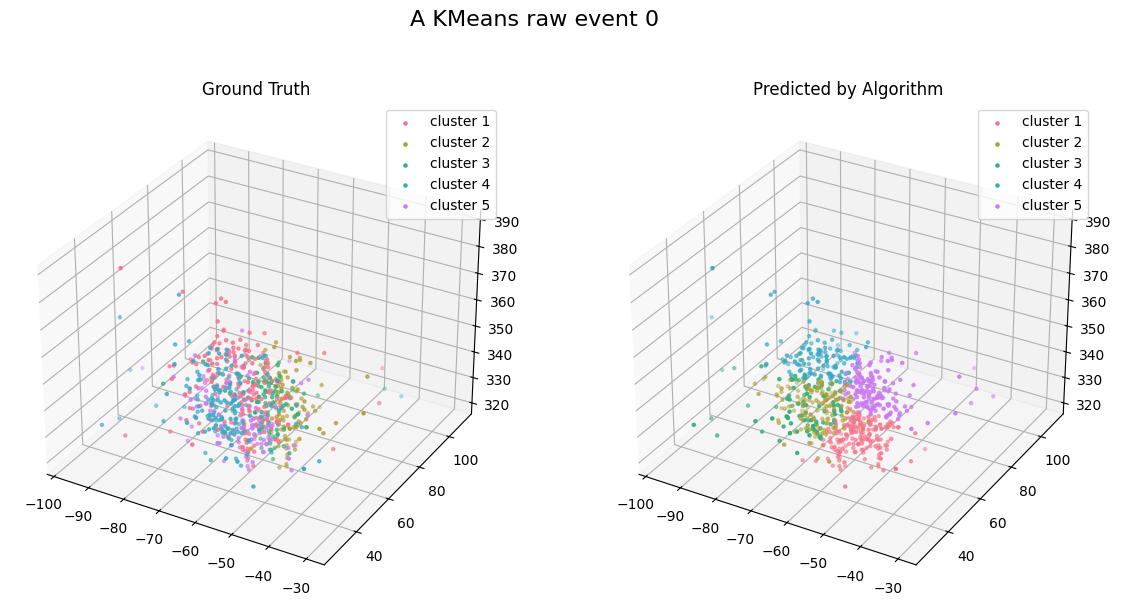

===== Cluster 1 =====	|| total energy: 295.1299743652344 	|| ground truth length: 161 	|| prediction length: 253 	|| intersection length: 75
purity: 0.2964426877470356	|| cluster_energy: 225.18527221679688 	|| weighted_purity: 0.7630037069320679	|| containment: 0.803606390953064
===== Cluster 2 =====	|| total energy: 256.0602111816406 	|| ground truth length: 182 	|| prediction length: 238 	|| intersection length: 105
purity: 0.4411764705882353	|| cluster_energy: 189.31967163085938 	|| weighted_purity: 0.7393561005592346	|| containment: 0.7393561005592346
===== Cluster 3 =====	|| total energy: 125.26042175292969 	|| ground truth length: 124 	|| prediction length: 120 	|| intersection length: 35
purity: 0.2916666666666667	|| cluster_energy: 21.680509567260742 	|| weighted_purity: 0.17308348417282104	|| containment: 0.6924559473991394
===== Cluster 4 =====	|| total energy: 58.757362365722656 	|| ground truth length: 108 	|| prediction length: 24 	|| intersection length: 5
purity: 0.20833

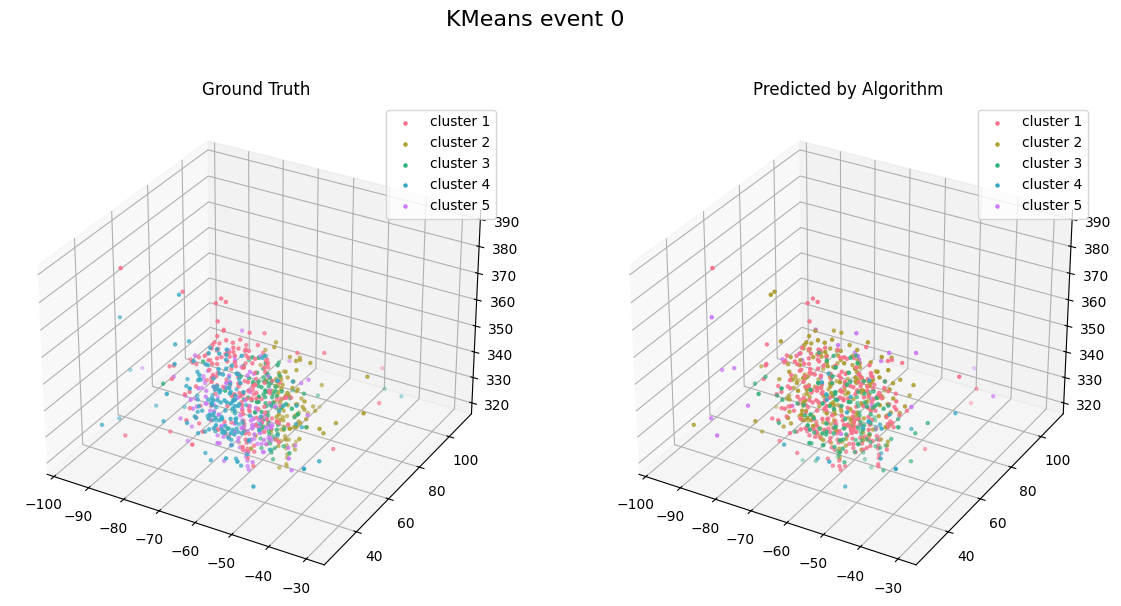

Running evaluation for event 1
===== Cluster 1 =====	|| total energy: 337.51629638671875 	|| ground truth length: 274 	|| prediction length: 195 	|| intersection length: 16
purity: 0.08205128205128205	|| cluster_energy: 1.309044361114502 	|| weighted_purity: 0.0038784625940024853	|| containment: 0.965656042098999
===== Cluster 2 =====	|| total energy: 159.761962890625 	|| ground truth length: 194 	|| prediction length: 152 	|| intersection length: 12
purity: 0.07894736842105263	|| cluster_energy: 0.5605601668357849 	|| weighted_purity: 0.003508721012622118	|| containment: 0.7654351592063904
===== Cluster 3 =====	|| total energy: 124.57107543945312 	|| ground truth length: 144 	|| prediction length: 145 	|| intersection length: 12
purity: 0.08275862068965517	|| cluster_energy: 0.6250016689300537 	|| weighted_purity: 0.005017229355871677	|| containment: 0.9245963096618652
===== Cluster 4 =====	|| total energy: 116.73407745361328 	|| ground truth length: 139 	|| prediction length: 172 	||

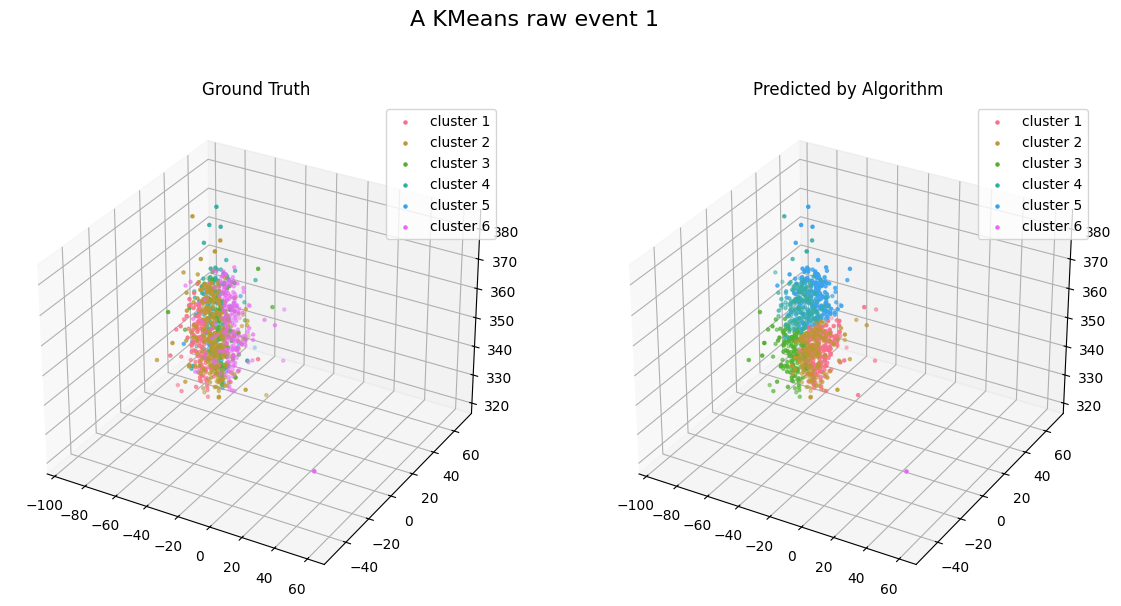

===== Cluster 1 =====	|| total energy: 337.51629638671875 	|| ground truth length: 274 	|| prediction length: 113 	|| intersection length: 81
purity: 0.7168141592920354	|| cluster_energy: 186.20314025878906 	|| weighted_purity: 0.5516863465309143	|| containment: 0.6160315275192261
===== Cluster 2 =====	|| total energy: 159.761962890625 	|| ground truth length: 194 	|| prediction length: 226 	|| intersection length: 12
purity: 0.05309734513274336	|| cluster_energy: 0.5766506791114807 	|| weighted_purity: 0.0036094365641474724	|| containment: 0.4810086786746979
===== Cluster 3 =====	|| total energy: 124.57107543945312 	|| ground truth length: 144 	|| prediction length: 54 	|| intersection length: 28
purity: 0.5185185185185185	|| cluster_energy: 107.01554107666016 	|| weighted_purity: 0.8590721487998962	|| containment: 0.8590721487998962
===== Cluster 4 =====	|| total energy: 116.73407745361328 	|| ground truth length: 139 	|| prediction length: 310 	|| intersection length: 47
purity: 0.1

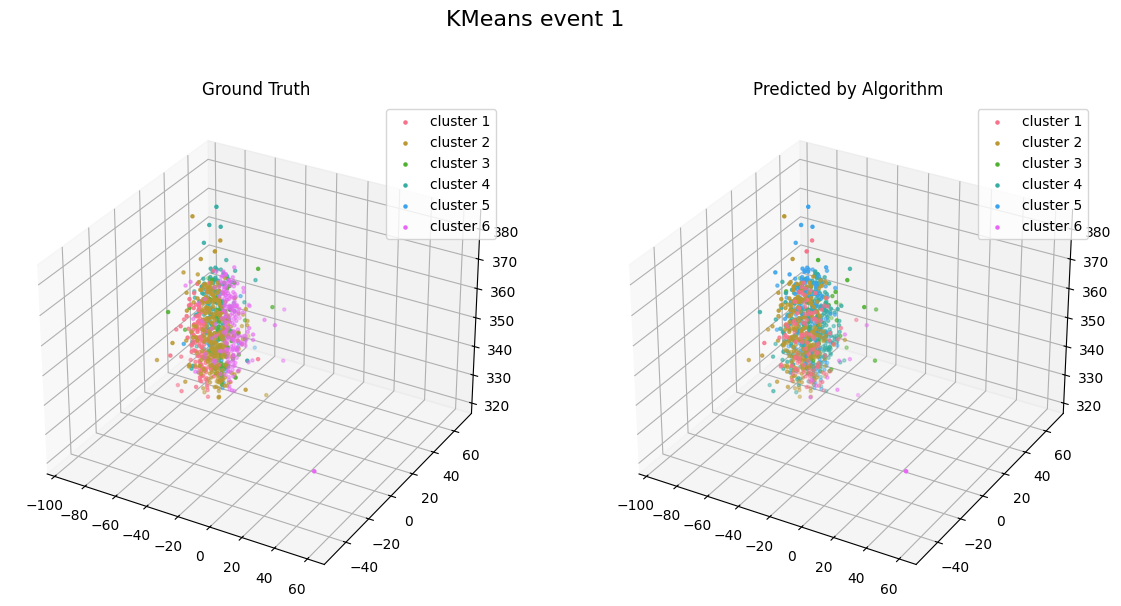

Running evaluation for event 2
===== Cluster 1 =====	|| total energy: 390.03955078125 	|| ground truth length: 232 	|| prediction length: 245 	|| intersection length: 107
purity: 0.43673469387755104	|| cluster_energy: 331.1533203125 	|| weighted_purity: 0.8490249514579773	|| containment: 0.8490249514579773
===== Cluster 2 =====	|| total energy: 338.5059814453125 	|| ground truth length: 249 	|| prediction length: 244 	|| intersection length: 188
purity: 0.7704918032786885	|| cluster_energy: 328.92626953125 	|| weighted_purity: 0.9717000126838684	|| containment: 0.9717000126838684
===== Cluster 3 =====	|| total energy: 307.7803649902344 	|| ground truth length: 256 	|| prediction length: 248 	|| intersection length: 119
purity: 0.4798387096774194	|| cluster_energy: 56.371185302734375 	|| weighted_purity: 0.1831539422273636	|| containment: 0.1831539422273636


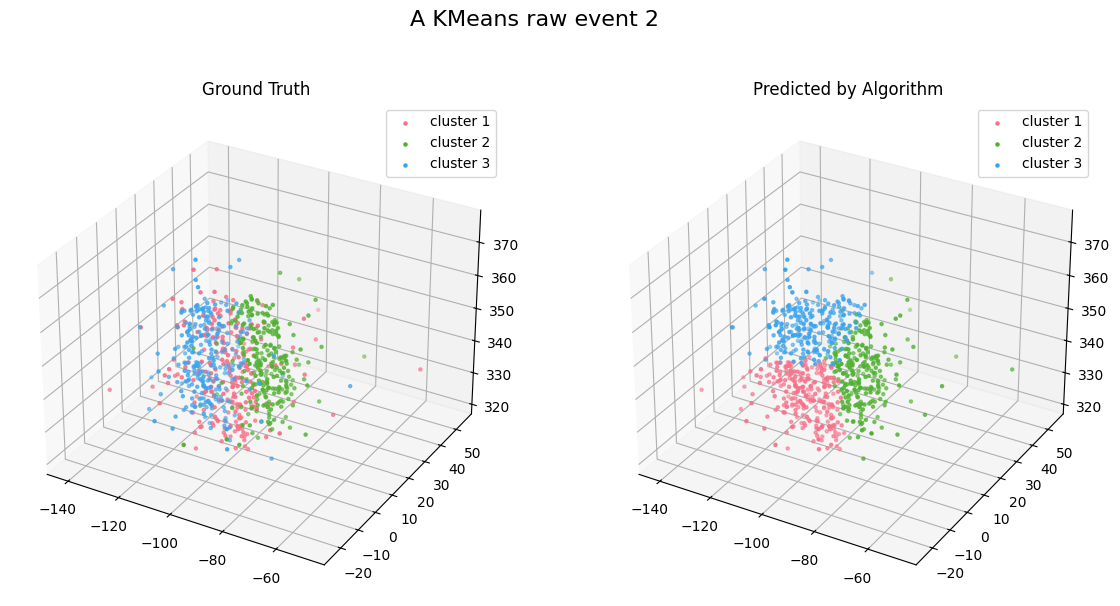

===== Cluster 1 =====	|| total energy: 390.03955078125 	|| ground truth length: 232 	|| prediction length: 413 	|| intersection length: 98
purity: 0.23728813559322035	|| cluster_energy: 263.74609375 	|| weighted_purity: 0.6762034893035889	|| containment: 0.7649274468421936
===== Cluster 2 =====	|| total energy: 338.5059814453125 	|| ground truth length: 249 	|| prediction length: 148 	|| intersection length: 79
purity: 0.5337837837837838	|| cluster_energy: 170.60169982910156 	|| weighted_purity: 0.503984272480011	|| containment: 0.503984272480011
===== Cluster 3 =====	|| total energy: 307.7803649902344 	|| ground truth length: 256 	|| prediction length: 176 	|| intersection length: 29
purity: 0.16477272727272727	|| cluster_energy: 4.2369561195373535 	|| weighted_purity: 0.013766167685389519	|| containment: 0.32122802734375


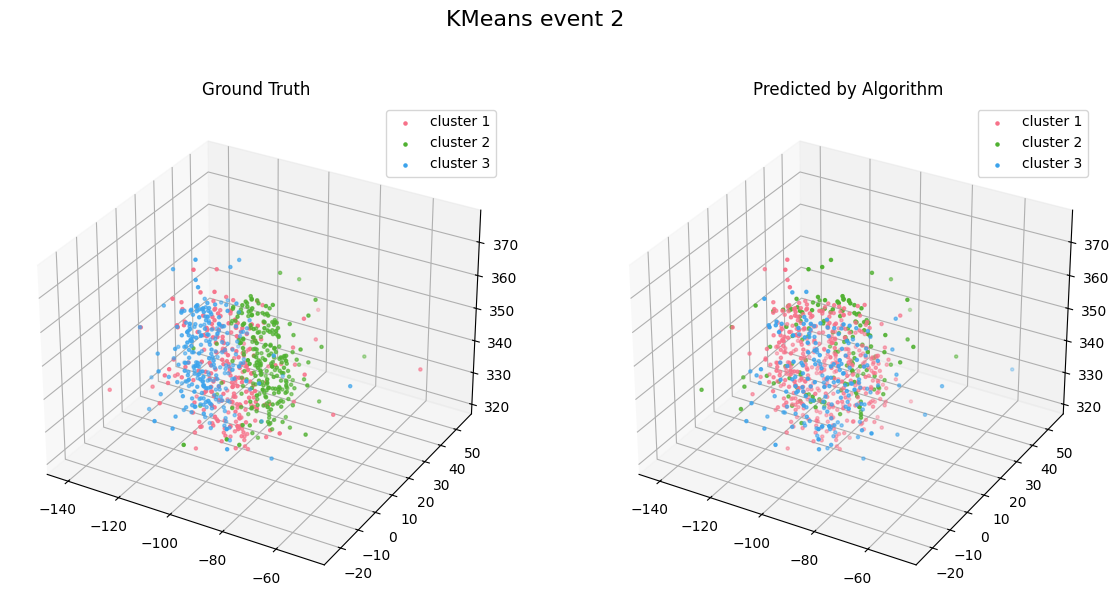

Running evaluation for event 3
===== Cluster 1 =====	|| total energy: 273.6422424316406 	|| ground truth length: 227 	|| prediction length: 210 	|| intersection length: 83
purity: 0.3952380952380952	|| cluster_energy: 168.07821655273438 	|| weighted_purity: 0.6142261624336243	|| containment: 0.9786242246627808
===== Cluster 2 =====	|| total energy: 168.43661499023438 	|| ground truth length: 247 	|| prediction length: 152 	|| intersection length: 125
purity: 0.8223684210526315	|| cluster_energy: 140.0985107421875 	|| weighted_purity: 0.8317580223083496	|| containment: 0.8317580223083496
===== Cluster 3 =====	|| total energy: 118.52715301513672 	|| ground truth length: 165 	|| prediction length: 168 	|| intersection length: 3
purity: 0.017857142857142856	|| cluster_energy: 0.24066849052906036 	|| weighted_purity: 0.002030492527410388	|| containment: 0.3790489733219147
===== Cluster 4 =====	|| total energy: 77.64279174804688 	|| ground truth length: 101 	|| prediction length: 151 	|| int

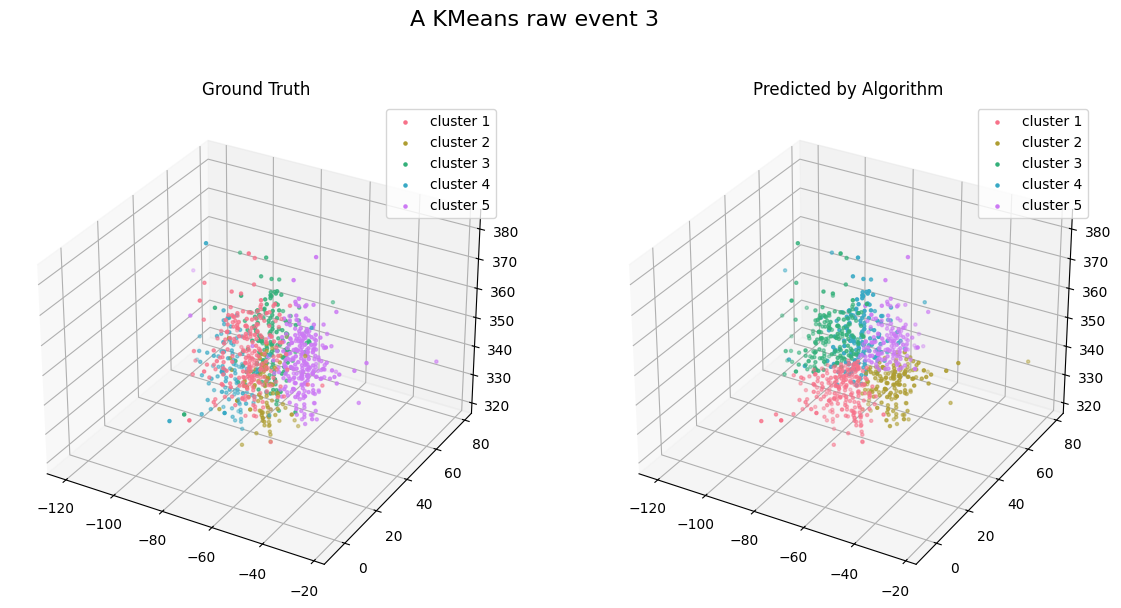

===== Cluster 1 =====	|| total energy: 273.6422424316406 	|| ground truth length: 227 	|| prediction length: 201 	|| intersection length: 86
purity: 0.42786069651741293	|| cluster_energy: 230.14573669433594 	|| weighted_purity: 0.8410460948944092	|| containment: 0.8410460948944092
===== Cluster 2 =====	|| total energy: 168.43661499023438 	|| ground truth length: 247 	|| prediction length: 307 	|| intersection length: 107
purity: 0.3485342019543974	|| cluster_energy: 62.15436553955078 	|| weighted_purity: 0.3690074384212494	|| containment: 0.827816903591156
===== Cluster 3 =====	|| total energy: 118.52715301513672 	|| ground truth length: 165 	|| prediction length: 56 	|| intersection length: 44
purity: 0.7857142857142857	|| cluster_energy: 104.05602264404297 	|| weighted_purity: 0.8779087066650391	|| containment: 0.8779087066650391
===== Cluster 4 =====	|| total energy: 77.64279174804688 	|| ground truth length: 101 	|| prediction length: 54 	|| intersection length: 4
purity: 0.0740740

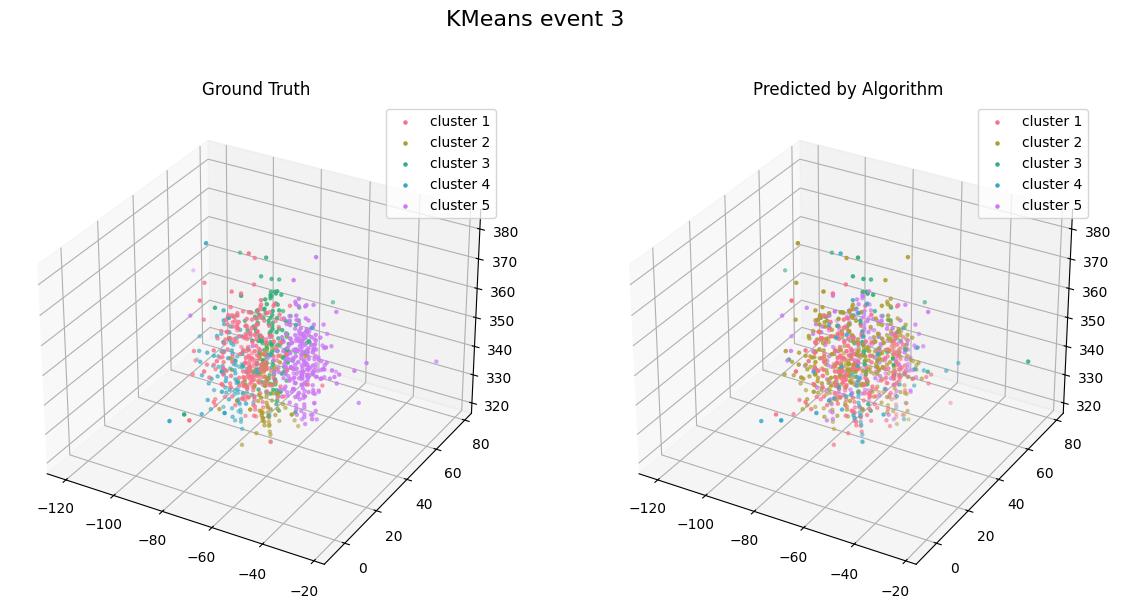

Running evaluation for event 4
===== Cluster 1 =====	|| total energy: 291.7923583984375 	|| ground truth length: 187 	|| prediction length: 152 	|| intersection length: 74
purity: 0.4868421052631579	|| cluster_energy: 246.17567443847656 	|| weighted_purity: 0.8436673283576965	|| containment: 0.8436673283576965
===== Cluster 2 =====	|| total energy: 203.343505859375 	|| ground truth length: 155 	|| prediction length: 144 	|| intersection length: 28
purity: 0.19444444444444445	|| cluster_energy: 1.518947958946228 	|| weighted_purity: 0.00746986223384738	|| containment: 0.8571345210075378
===== Cluster 3 =====	|| total energy: 172.54798889160156 	|| ground truth length: 201 	|| prediction length: 181 	|| intersection length: 20
purity: 0.11049723756906077	|| cluster_energy: 1.039851427078247 	|| weighted_purity: 0.0060264477506279945	|| containment: 0.9674900770187378
===== Cluster 4 =====	|| total energy: 144.0154266357422 	|| ground truth length: 180 	|| prediction length: 151 	|| inter

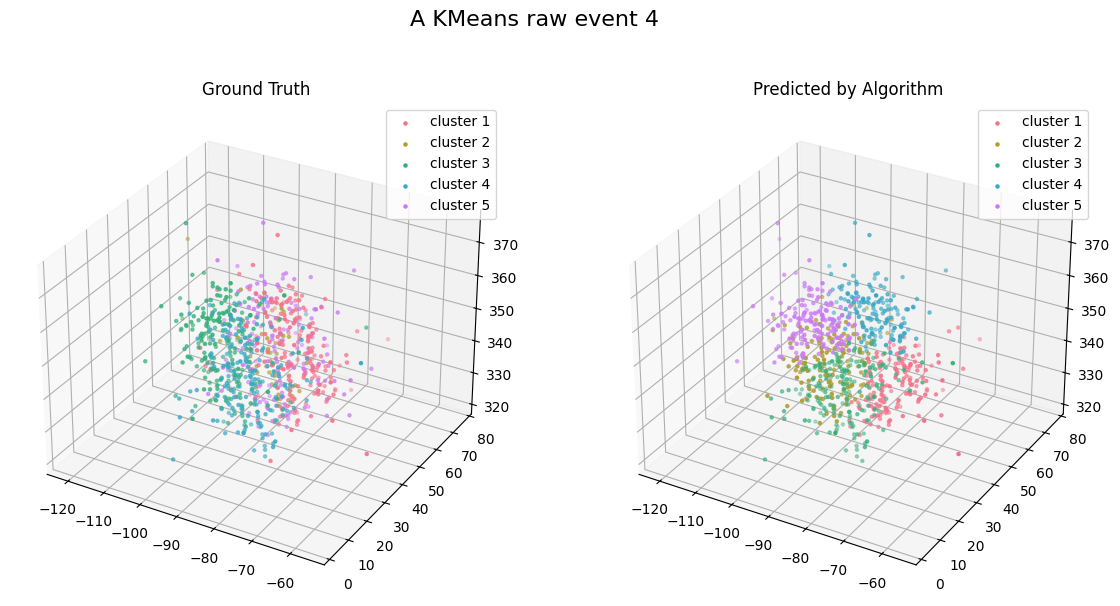

===== Cluster 1 =====	|| total energy: 291.7923583984375 	|| ground truth length: 187 	|| prediction length: 268 	|| intersection length: 59
purity: 0.22014925373134328	|| cluster_energy: 255.33876037597656 	|| weighted_purity: 0.8750700950622559	|| containment: 0.9070804715156555
===== Cluster 2 =====	|| total energy: 203.343505859375 	|| ground truth length: 155 	|| prediction length: 57 	|| intersection length: 27
purity: 0.47368421052631576	|| cluster_energy: 114.1222152709961 	|| weighted_purity: 0.5612286925315857	|| containment: 0.7919949889183044
===== Cluster 3 =====	|| total energy: 172.54798889160156 	|| ground truth length: 201 	|| prediction length: 42 	|| intersection length: 1
purity: 0.023809523809523808	|| cluster_energy: 0.19185711443424225 	|| weighted_purity: 0.0011119057890027761	|| containment: 0.787559449672699
===== Cluster 4 =====	|| total energy: 144.0154266357422 	|| ground truth length: 180 	|| prediction length: 284 	|| intersection length: 50
purity: 0.176

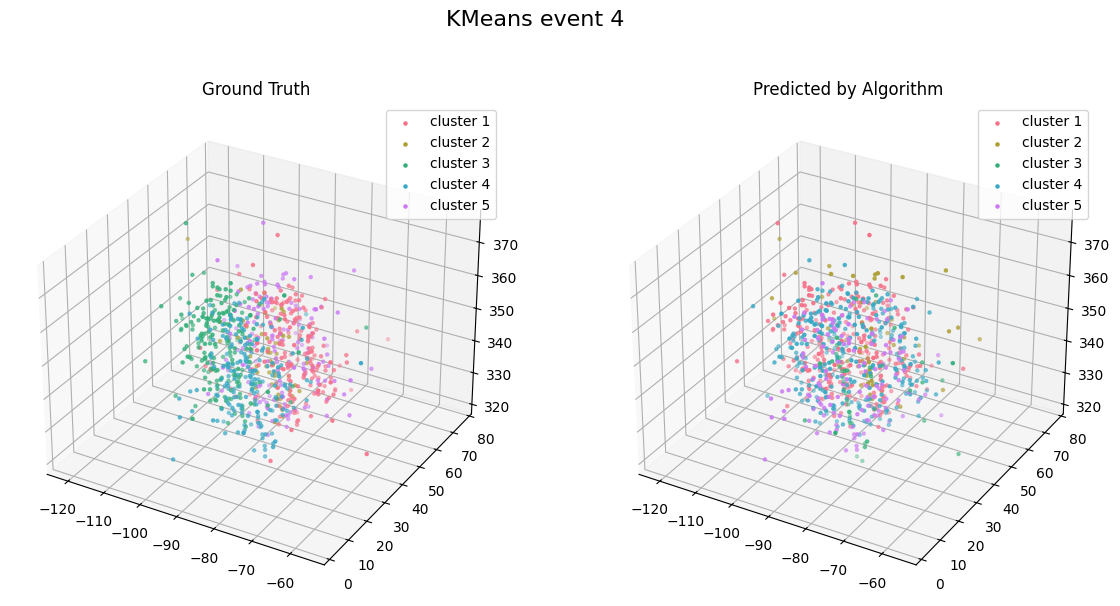

Running evaluation for event 5
===== Cluster 1 =====	|| total energy: 339.99664306640625 	|| ground truth length: 265 	|| prediction length: 216 	|| intersection length: 58
purity: 0.26851851851851855	|| cluster_energy: 212.01089477539062 	|| weighted_purity: 0.6235676407814026	|| containment: 0.9641999006271362
===== Cluster 2 =====	|| total energy: 312.7411804199219 	|| ground truth length: 199 	|| prediction length: 181 	|| intersection length: 1
purity: 0.0055248618784530384	|| cluster_energy: 0.039610572159290314 	|| weighted_purity: 0.0001266560866497457	|| containment: 0.9428617358207703
===== Cluster 3 =====	|| total energy: 254.6978759765625 	|| ground truth length: 214 	|| prediction length: 193 	|| intersection length: 101
purity: 0.5233160621761658	|| cluster_energy: 5.93294620513916 	|| weighted_purity: 0.023294053971767426	|| containment: 0.6023644804954529
===== Cluster 4 =====	|| total energy: 207.1654815673828 	|| ground truth length: 215 	|| prediction length: 132 	||

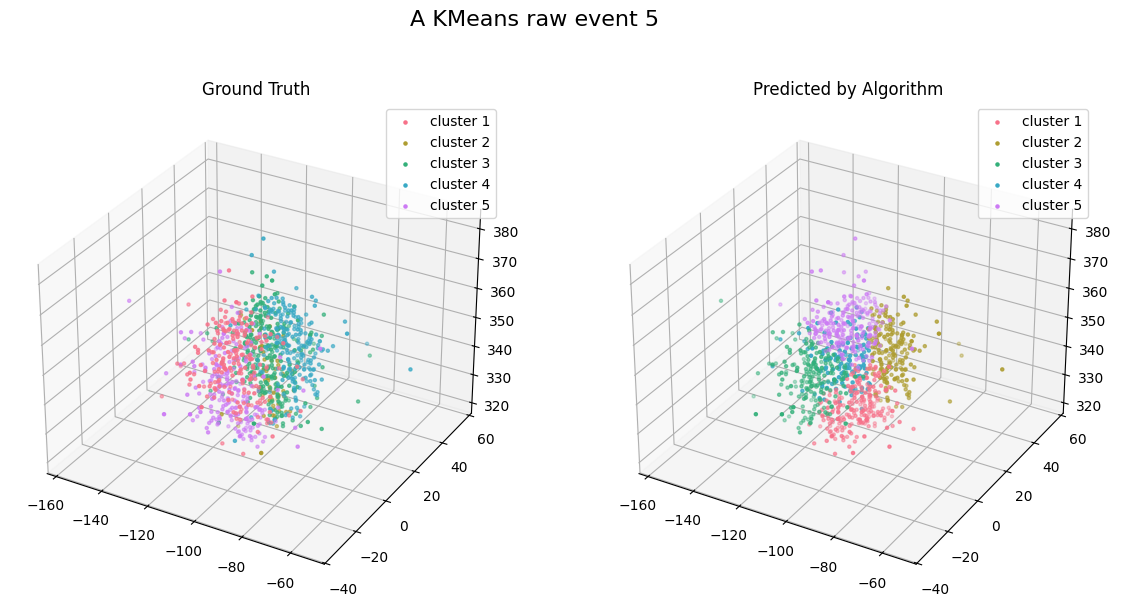

===== Cluster 1 =====	|| total energy: 339.99664306640625 	|| ground truth length: 265 	|| prediction length: 483 	|| intersection length: 155
purity: 0.32091097308488614	|| cluster_energy: 95.0606689453125 	|| weighted_purity: 0.27959296107292175	|| containment: 0.7699564099311829
===== Cluster 2 =====	|| total energy: 312.7411804199219 	|| ground truth length: 199 	|| prediction length: 154 	|| intersection length: 7
purity: 0.045454545454545456	|| cluster_energy: 0.16659437119960785 	|| weighted_purity: 0.0005326908431015909	|| containment: 0.8679308295249939
===== Cluster 3 =====	|| total energy: 254.6978759765625 	|| ground truth length: 214 	|| prediction length: 257 	|| intersection length: 81
purity: 0.3151750972762646	|| cluster_energy: 57.83274841308594 	|| weighted_purity: 0.2270641177892685	|| containment: 0.8232574462890625
===== Cluster 4 =====	|| total energy: 207.1654815673828 	|| ground truth length: 215 	|| prediction length: 41 	|| intersection length: 6
purity: 0.14

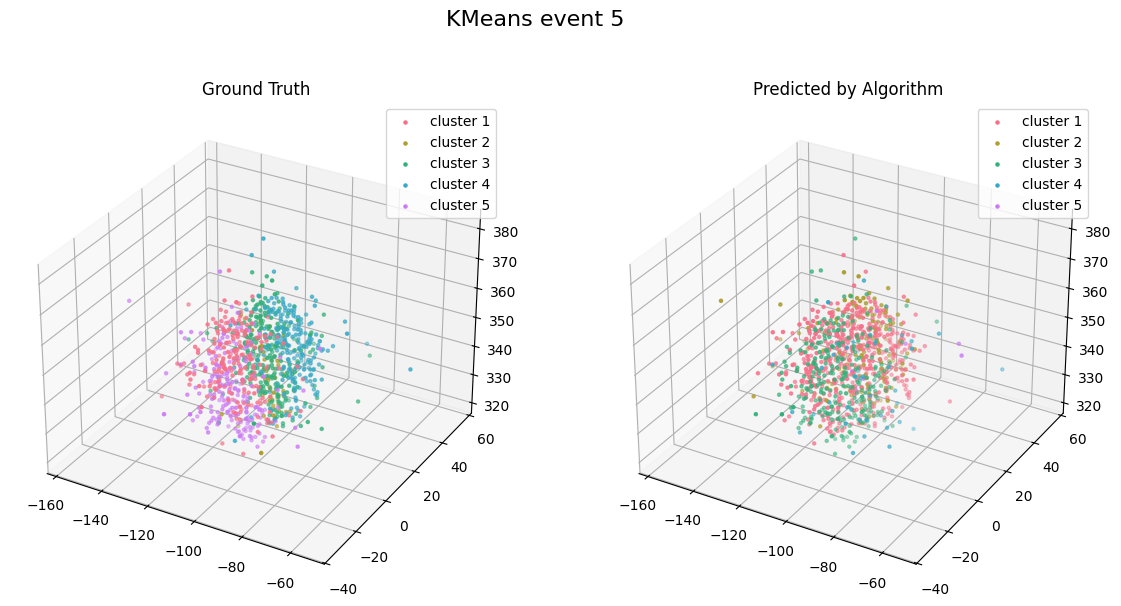

Running evaluation for event 6
===== Cluster 1 =====	|| total energy: 296.4503173828125 	|| ground truth length: 241 	|| prediction length: 183 	|| intersection length: 58
purity: 0.31693989071038253	|| cluster_energy: 175.0723114013672 	|| weighted_purity: 0.5905620455741882	|| containment: 0.8246612548828125
===== Cluster 2 =====	|| total energy: 144.07664489746094 	|| ground truth length: 135 	|| prediction length: 158 	|| intersection length: 23
purity: 0.14556962025316456	|| cluster_energy: 45.74001693725586 	|| weighted_purity: 0.3174700438976288	|| containment: 0.35860034823417664
===== Cluster 3 =====	|| total energy: 134.31216430664062 	|| ground truth length: 131 	|| prediction length: 179 	|| intersection length: 17
purity: 0.09497206703910614	|| cluster_energy: 0.9060719013214111 	|| weighted_purity: 0.006746015045791864	|| containment: 0.868476927280426
===== Cluster 4 =====	|| total energy: 71.2257080078125 	|| ground truth length: 120 	|| prediction length: 180 	|| inter

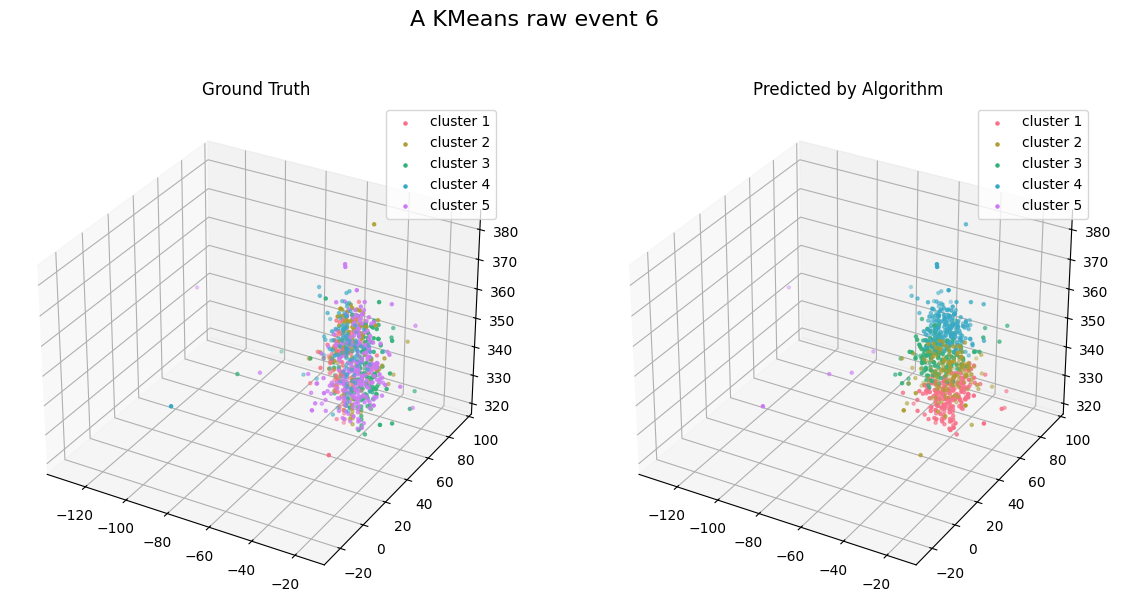

===== Cluster 1 =====	|| total energy: 296.4503173828125 	|| ground truth length: 241 	|| prediction length: 221 	|| intersection length: 125
purity: 0.5656108597285068	|| cluster_energy: 267.568359375 	|| weighted_purity: 0.9025740623474121	|| containment: 0.9390157461166382
===== Cluster 2 =====	|| total energy: 144.07664489746094 	|| ground truth length: 135 	|| prediction length: 337 	|| intersection length: 81
purity: 0.2403560830860534	|| cluster_energy: 9.898276329040527 	|| weighted_purity: 0.06870146095752716	|| containment: 0.9799008369445801
===== Cluster 3 =====	|| total energy: 134.31216430664062 	|| ground truth length: 131 	|| prediction length: 100 	|| intersection length: 5
purity: 0.05	|| cluster_energy: 0.1675964593887329 	|| weighted_purity: 0.001247812993824482	|| containment: 0.9482769966125488
===== Cluster 4 =====	|| total energy: 71.2257080078125 	|| ground truth length: 120 	|| prediction length: 32 	|| intersection length: 0
purity: 0.0	|| cluster_energy: 0.0

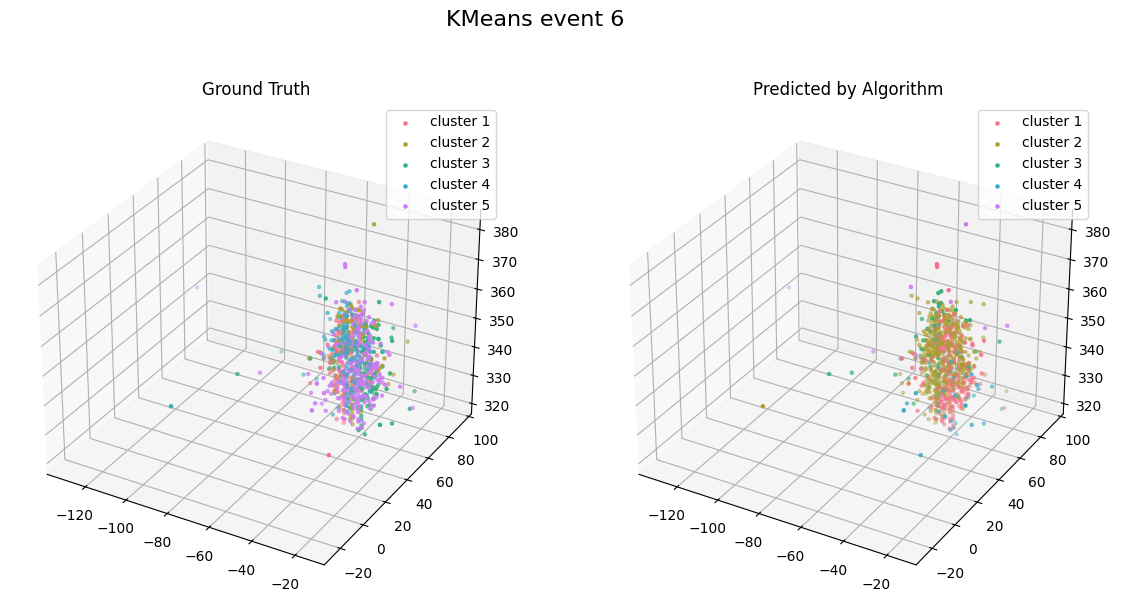

<ipython-input-77-fffda67d658b>:207: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = cm.get_cmap('gist_heat_r', len(methods_used) + 1)
<ipython-input-77-fffda67d658b>:241: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color_pool = plt.cm.get_cmap('tab10', len(methods_info))


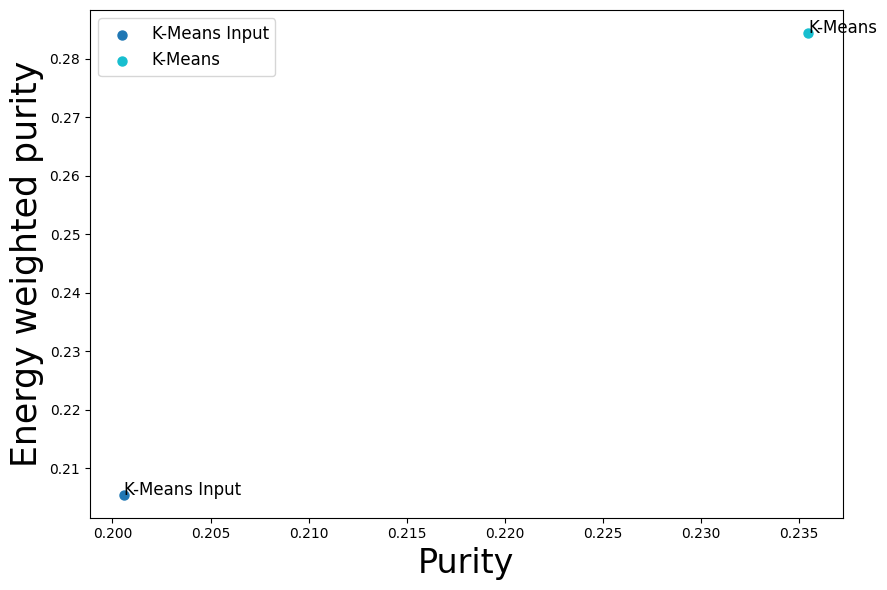

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import scipy

def geo_mean(x_list, use_arithmetic_mean=True):
    """
    Computes the mean of x_list. Uses arithmetic mean if use_arithmetic_mean=True.
    Otherwise, uses geometric mean.
    """
    if use_arithmetic_mean:
        return np.mean(x_list)
    return np.exp(np.mean(np.log(x_list)))


def extract_ordered_data(data_dict):
    """
    Given a dictionary of key -> list_of_values,
    returns two numpy arrays:
      (1) array of repeated keys,
      (2) flattened array of values.
    """
    keys_ordered = []
    values_ordered = []
    for key, val_list in data_dict.items():
        keys_ordered.extend([key] * len(val_list))
        values_ordered.extend(val_list)
    return np.array(keys_ordered), np.array(values_ordered)
import numpy as np
import matplotlib.pyplot as plt

def evaluate_model(data, idx, sim_threshold, temperature, number_of_attention, layer_of_attention,
                   model_name, device, net, data_title, SPARSE, save=False, similarity_matrix=None,
                   clustering_method=None, opath=None, is_ticl=False):

    this_data = data[idx].to(device)
    if model_name == 'DGCNN':
        out = net(this_data.x, this_data.batch)

    data_to_device = this_data.to(device).x.cpu().detach().numpy()
    out = out.to(device)
    actual_length = len(data.stsCP_vertices_energy[idx])

    clustering = Layer_wise_Cluster(
        out,
        data_to_device,
        sim_threshold,
        temperature,
        number_of_attention,
        layer_of_attention,
        similarity_matrix=similarity_matrix,
        sparse=SPARSE,
        save=save,
        index=idx,
        clustering_method=clustering_method,
        opath=opath,
        number_of_clusters=actual_length
    )

    # (Example) count cluster elements
    num = 0
    for keys in clustering.cluster.keys():
        num += len(clustering.cluster[keys])

    Make_graph = True
    comparison_method = Comparison(
        clustering, data, idx, model_name, device, net, data_title, Make_graph
    )

    return [comparison_method]
def evaluate_model(data,
                   idx,
                   sim_threshold,
                   temperature,
                   number_of_attention,
                   layer_of_attention,
                   model_name,
                   device,
                   net,
                   data_title,
                   SPARSE,
                   save=False,
                   similarity_matrix=None,
                   clustering_method=None,
                   opath=None,
                   is_ticl=False):
    """
    Runs a forward pass of the model (optionally DGCNN) on data[idx],
    performs clustering, and returns a comparison object.
    """


    this_data = data[idx].to(device)
    if model_name == 'DGCNN':
        out = net(this_data.x, this_data.batch)
    else:
        # If your model doesn't need batch, or if it's another model

        out = net(this_data.x)


    data_to_device = this_data.to(device).x.cpu().detach().numpy()

    # (Optional) ensure 'out' is on the same device you want
    out = out.to(device)


    actual_length = len(data.stsCP_vertices_energy[idx])

    # Perform clustering using a function like Layer_wise_Cluster
    clustering = Layer_wise_Cluster(
        out,
        data_to_device,
        sim_threshold,
        temperature,
        number_of_attention,
        layer_of_attention,
        similarity_matrix=similarity_matrix,
        sparse=SPARSE,
        save=save,
        index=idx,
        clustering_method=clustering_method,
        opath=opath,
        number_of_clusters=actual_length
    )

    # Example: counting elements in each cluster
    num = 0
    for key in clustering.cluster.keys():
        num += len(clustering.cluster[key])

    # Possibly plot or do some comparison
    Make_graph = True
    comparison_method = Comparison(
        clustering, data, idx, model_name, device, net, data_title, Make_graph
    )

    return [comparison_method]


def run_evaluation(
    data, net, device, model_name, data_title, threshold, temperature,
    ATTENTION_NUMBER, ATTENTION_LAYER, SPARSE=False, save=False,
    clustering_method=None, opath=None
):
    """
    Orchestrates the entire evaluation pipeline for a given dataset
    and prints/scatters final results.
    """
    print(f"Running evaluation for {data_title} with {model_name}")
    print(f"Threshold: {threshold}, Temperature: {temperature}, "
          f"Number of attention: {ATTENTION_NUMBER}, Layer of attention: {ATTENTION_LAYER}")
    print(f"Clustering method: {clustering_method}")
    print(f"Using sparse matrix: {SPARSE}, Save: {save}")
    print(f"Number of events: {len(data)}")

    comparisons_method = []
    methods_dict = {}
    all_vals = {}
    methods_mets = {}

    methods_info = {
        'A KMeans raw': [1],
        'KMeans': [1]
    }

    # Flatten the methods_info into arrays
    methods_used, methods_used_tol = extract_ordered_data(methods_info)

    # Limit events processed for demonstration;
    # adjust or remove min(...) to process full dataset.
    num_events = min(7, len(data))

    for idx in range(num_events):
        print('==============================')
        print(f"Running evaluation for event {idx}")

        matrix_comparisons = []
        # Evaluate each method in methods_used
        for i_tol, method in enumerate(methods_used):

            comparison = evaluate_model(
                data,
                idx,
                methods_used_tol[i_tol],
                temperature,
                ATTENTION_NUMBER,
                ATTENTION_LAYER,
                model_name,
                device,
                net,
                method,
                SPARSE=SPARSE,
                save=save,
                similarity_matrix=None,
                clustering_method=method,
                opath=opath,
                is_ticl=False
            )
            matrix_comparisons.append(comparison)

        # Flatten comparisons
        comparison_method = [c[0] for c in matrix_comparisons]
        comparisons_method.append(comparison_method)

    # Visualization / metric computation
    colormap = cm.get_cmap('gist_heat_r', len(methods_used) + 1)
    colors = [colormap(i) for i in range(len(methods_used) + 1)]

    # Gather purity metrics for each method
    for method_idx in range(len(matrix_comparisons)):
        total_purity = []
        total_weighted_purity = []
        # Loop over each event's results
        for event_comparisons in comparisons_method:
            # event_comparisons -> list of comparisons for all methods in a single event
            # event_comparisons[method_idx] -> the comparison for our target method index
            comp_obj = event_comparisons[method_idx]
            purities = comp_obj.purity[0]
            weighted_purities = comp_obj.purity[1]

            total_purity.extend(purities)
            total_weighted_purity.extend(weighted_purities)

        # Compute means or geometric means
        method_key = f"{methods_used[method_idx]}:{methods_used_tol[method_idx]}"
        avg_purity = geo_mean(total_purity)
        avg_weighted_purity = geo_mean(total_weighted_purity)

        # Store final metrics
        methods_dict[method_key] = [avg_purity, avg_weighted_purity]

        # Example of storing all vals for variance, etc.
        combined_vals = np.array(
            [p * w for p, w in zip(total_purity, total_weighted_purity)]
        )
        methods_mets[method_key] = [np.var(combined_vals), np.mean(combined_vals)]

    # Assign distinct colors by method prefix
    color_map = {}
    color_pool = plt.cm.get_cmap('tab10', len(methods_info))
    used_prefixes = set()

    # Build color mapping
    for method in methods_dict.keys():
        prefix, _ = method.split(':')
        if prefix not in color_map:
            color_map[prefix] = color_pool(len(color_map))

    # Plot results
    fig, ax = plt.subplots(figsize=(9, 6))
    ax.set_xlabel('Purity', fontsize=24)
    ax.set_ylabel('Energy weighted purity', fontsize=25)

    for method, (pur, wpur) in methods_dict.items():
        prefix, suffix = method.split(':')
        scatter_label = None

        # Provide a user-friendly label
        if prefix == 'A KMeans raw':
            scatter_label = 'K-Means Input'
        elif prefix == 'KMeans':
            scatter_label = 'K-Means'

        # Show prefix label only once
        plot_label = scatter_label if prefix not in used_prefixes else None
        used_prefixes.add(prefix)

        ax.scatter(
            pur, wpur,
            label=plot_label,
            color=color_map[prefix],
            s=42
        )
        ax.annotate(scatter_label, (pur, wpur), fontsize=12)

    if used_prefixes:
        ax.legend(fontsize=12, loc='best')

    plt.tight_layout()
    plt.show()
    #plot_purity_vs_weighted_purity(comparisons_method, methods_dict, methods_used)
    # Return whatever final comparisons or metrics you want
    return comparisons_method
comparisons = run_evaluation(data_test, cc, device, model, 'Test', threshold = 0.8, temperature = 1, ATTENTION_NUMBER = 4, ATTENTION_LAYER = ATTENTION_LAYER, SPARSE = False, save = False, clustering_method = 'Variable', opath = opath)


Conclusion and Future Directions
This notebook illustrates how GNNs can significantly improve particle shower reconstruction by modeling detector data as graphs. By designing an alignment-diffusion loss, we encourage the network to produce discriminative embeddings conducive to clustering. In future work, one might incorporate more physics-inspired features, experiment with different neighborhood definitions, or deploy specialized GNN architectures (e.g., attention-based) to further refine real-time event classification under challenging detector conditions.

